For model baseline, got accuracy: 0.932000
For model regularized, got accuracy: 0.965300


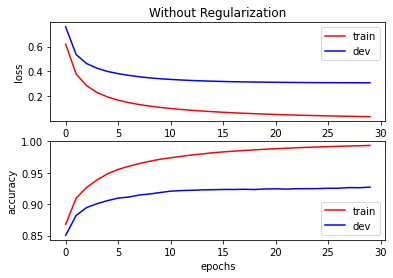

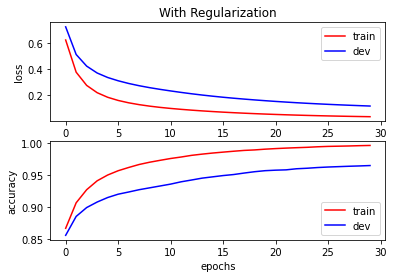

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import argparse

def softmax(x):
    """
    Compute softmax function for a batch of input values. 
    The first dimension of the input corresponds to the batch size. The second dimension
    corresponds to every class in the output. When implementing softmax, you should be careful
    to only sum over the second dimension.

    Important Note: You must be careful to avoid overflow for this function. Functions
    like softmax have a tendency to overflow when very large numbers like e^10000 are computed.
    You will know that your function is overflow resistent when it can handle input like:
    np.array([[10000, 10010, 10]]) without issues.

    Args:
        x: A 2d numpy float array of shape batch_size x number_of_classes

    Returns:
        A 2d numpy float array containing the softmax results of shape batch_size x number_of_classes
    """
    # *** START CODE HERE ***
    max_x = np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x - max_x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    # *** END CODE HERE ***

def sigmoid(x):
    """
    Compute the sigmoid function for the input here.

    Args:
        x: A numpy float array

    Returns:
        A numpy float array containing the sigmoid results
    """
    # *** START CODE HERE ***
    return 1 / (1 + np.exp(-x))
    # *** END CODE HERE ***

def get_initial_params(input_size, num_hidden, num_output):
    """
    Compute the initial parameters for the neural network.

    This function should return a dictionary mapping parameter names to numpy arrays containing
    the initial values for those parameters.

    There should be four parameters for this model:
    W1 is the weight matrix for the hidden layer of size input_size x num_hidden
    b1 is the bias vector for the hidden layer of size num_hidden
    W2 is the weight matrix for the output layers of size num_hidden x num_output
    b2 is the bias vector for the output layer of size num_output

    As specified in the PDF, weight matrices should be initialized with a random normal distribution
    centered on zero and with scale 1.
    Bias vectors should be initialized with zero.
    
    Args:
        input_size: The size of the input data
        num_hidden: The number of hidden states
        num_output: The number of output classes
    
    Returns:
        A dict mapping parameter names to numpy arrays
    """

    # *** START CODE HERE ***
    W1 = np.random.normal(0, 1, size=(num_hidden, input_size))
    b1 = np.zeros(num_hidden)
    W2 = np.random.normal(0, 1, size=(num_output, num_hidden))
    b2 = np.zeros(num_output)
    params = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    return params
    # *** END CODE HERE ***

def forward_prop(data, labels, params):
    """
    Implement the forward layer given the data, labels, and params.
    
    Args:
        data: A numpy array containing the input
        labels: A 2d numpy array containing the labels
        params: A dictionary mapping parameter names to numpy arrays with the parameters.
            This numpy array will contain W1, b1, W2 and b2
            W1 and b1 represent the weights and bias for the hidden layer of the network
            W2 and b2 represent the weights and bias for the output layer of the network

    Returns:
        A 3 element tuple containing:
            1. A numpy array of the activations (after the sigmoid) of the hidden layer
            2. A numpy array The output (after the softmax) of the output layer
            3. The average loss for these data elements
    """
    # *** START CODE HERE ***
    W1 = params['W1']
    b1 = params['b1']
    W2 = params['W2']
    b2 = params['b2']

    Z1 = data @ W1.T + b1
    A1 = sigmoid(Z1)
    Z2 = A1 @ W2.T + b2
    predcts = softmax(Z2)
    i = - np.sum(labels * np.log(predcts))
    i = i / len(data)
    return A1, predcts, i

    # *** END CODE HERE ***

def backward_prop(data, labels, params, forward_prop_func):
    """
    Implement the backward propegation gradient computation step for a neural network
    
    Args:
        data: A numpy array containing the input
        labels: A 2d numpy array containing the labels
        params: A dictionary mapping parameter names to numpy arrays with the parameters.
            This numpy array will contain W1, b1, W2 and b2
            W1 and b1 represent the weights and bias for the hidden layer of the network
            W2 and b2 represent the weights and bias for the output layer of the network
        forward_prop_func: A function that follows the forward_prop API above

    Returns:
        A dictionary of strings to numpy arrays where each key represents the name of a weight
        and the values represent the gradient of the loss with respect to that weight.
        
        In particular, it should have 4 elements:
            W1, W2, b1, and b2
    """
    # *** START CODE HERE ***
    W2 = params['W2']
    batch_len = len(data)
    # forward pass
    A1, predcts, loss = forward_prop_func(data, labels, params)
    # backward pass
    dZ2 = predcts - labels
    dW2 = dZ2.T @ A1 / batch_len
    db2 = np.sum(dZ2, axis=0) / batch_len
    dA1 = dZ2 @ W2
    dZ1 = A1 * (1 - A1) * dA1
    dW1 = dZ1.T @ data / batch_len
    db1 = np.sum(dZ1, axis=0) / batch_len
    # collect grads
    gradients = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}
    return gradients
    # *** END CODE HERE ***


def backward_prop_regularized(data, labels, params, forward_prop_func, reg):
    """
    Implement the backward propegation gradient computation step for a neural network
    
    Args:
        data: A numpy array containing the input
        labels: A 2d numpy array containing the labels
        params: A dictionary mapping parameter names to numpy arrays with the parameters.
            This numpy array will contain W1, b1, W2 and b2
            W1 and b1 represent the weights and bias for the hidden layer of the network
            W2 and b2 represent the weights and bias for the output layer of the network
        forward_prop_func: A function that follows the forward_prop API above
        reg: The regularization strength (lambda)

    Returns:
        A dictionary of strings to numpy arrays where each key represents the name of a weight
        and the values represent the gradient of the loss with respect to that weight.
        
        In particular, it should have 4 elements:
            W1, W2, b1, and b2
    """
    # *** START CODE HERE ***
    gradients = backward_prop(data, labels, params, forward_prop_func)

    gradients['W1'] += 2 * reg * params['W1']
    gradients['W2'] += 2 * reg * params['W2']
    
    return gradients
    # *** END CODE HERE ***

def gradient_descent_epoch(train_data, train_labels, learning_rate, batch_size, params, forward_prop_func, backward_prop_func):
    """
    Perform one epoch of gradient descent on the given training data using the provided learning rate.

    This code should update the parameters stored in params.
    It should not return anything

    Args:
        train_data: A numpy array containing the training data
        train_labels: A numpy array containing the training labels
        learning_rate: The learning rate
        batch_size: The amount of items to process in each batch
        params: A dict of parameter names to parameter values that should be updated.
        forward_prop_func: A function that follows the forward_prop API
        backward_prop_func: A function that follows the backwards_prop API

    Returns: This function returns nothing.
    """

    # *** START CODE HERE ***
    epoch_batches = int(np.ceil(len(train_data) / batch_size))
    # Batchify training data using numpy.array_split
    batches = np.array_split(train_data, epoch_batches)
    label_batches = np.array_split(train_labels, epoch_batches)

    # The training loop over batches
    for batch_data, batch_labels in zip(batches, label_batches):
        gradients = backward_prop_func(batch_data, batch_labels, params, forward_prop_func)
        # Update params using numpy.add
        for wt in ['W1', 'b1', 'W2', 'b2']:
            params[wt] -= learning_rate * gradients[wt]
    # *** END CODE HERE ***

    # This function does not return anything
    return

def nn_train(
    train_data, train_labels, dev_data, dev_labels, 
    get_initial_params_func, forward_prop_func, backward_prop_func,
    num_hidden=300, learning_rate=5, num_epochs=30, batch_size=1000):

    (nexp, dim) = train_data.shape

    params = get_initial_params_func(dim, num_hidden, 10)

    cost_train = []
    cost_dev = []
    accuracy_train = []
    accuracy_dev = []
    for epoch in range(num_epochs):
        gradient_descent_epoch(train_data, train_labels, 
            learning_rate, batch_size, params, forward_prop_func, backward_prop_func)

        h, output, cost = forward_prop_func(train_data, train_labels, params)
        cost_train.append(cost)
        accuracy_train.append(compute_accuracy(output,train_labels))
        h, output, cost = forward_prop_func(dev_data, dev_labels, params)
        cost_dev.append(cost)
        accuracy_dev.append(compute_accuracy(output, dev_labels))

    return params, cost_train, cost_dev, accuracy_train, accuracy_dev

def nn_test(data, labels, params):
    h, output, cost = forward_prop(data, labels, params)
    accuracy = compute_accuracy(output, labels)
    return accuracy

def compute_accuracy(output, labels):
    accuracy = (np.argmax(output,axis=1) == 
        np.argmax(labels,axis=1)).sum() * 1. / labels.shape[0]
    return accuracy

def one_hot_labels(labels):
    one_hot_labels = np.zeros((labels.size, 10))
    one_hot_labels[np.arange(labels.size),labels.astype(int)] = 1
    return one_hot_labels

def read_data(images_file, labels_file):
    x = np.loadtxt(images_file, delimiter=',')
    y = np.loadtxt(labels_file, delimiter=',')
    return x, y

def run_train_test(name, all_data, all_labels, backward_prop_func, num_epochs, plot=True):
    params, cost_train, cost_dev, accuracy_train, accuracy_dev = nn_train(
        all_data['train'], all_labels['train'], 
        all_data['dev'], all_labels['dev'],
        get_initial_params, forward_prop, backward_prop_func,
        num_hidden=300, learning_rate=5, num_epochs=num_epochs, batch_size=1000
    )

    t = np.arange(num_epochs)

    if plot:
        fig, (ax1, ax2) = plt.subplots(2, 1)

        ax1.plot(t, cost_train,'r', label='train')
        ax1.plot(t, cost_dev, 'b', label='dev')
        ax1.set_xlabel('epochs')
        ax1.set_ylabel('loss')
        if name == 'baseline':
            ax1.set_title('Without Regularization')
        else:
            ax1.set_title('With Regularization')
        ax1.legend()

        ax2.plot(t, accuracy_train,'r', label='train')
        ax2.plot(t, accuracy_dev, 'b', label='dev')
        ax2.set_xlabel('epochs')
        ax2.set_ylabel('accuracy')
        ax2.legend()

        fig.savefig('./' + name + '.pdf')

    accuracy = nn_test(all_data['test'], all_labels['test'], params)
    print('For model %s, got accuracy: %f' % (name, accuracy))
    
    return accuracy

def main(plot=True):
    parser = argparse.ArgumentParser(description='Train a nn model.')
    parser.add_argument('--num_epochs', type=int, default=30)

    args,unknown = parser.parse_known_args()

    np.random.seed(100)
    train_data, train_labels = read_data('./images_train.csv', './labels_train.csv')
    train_labels = one_hot_labels(train_labels)
    p = np.random.permutation(60000)
    train_data = train_data[p,:]
    train_labels = train_labels[p,:]

    dev_data = train_data[0:10000,:]
    dev_labels = train_labels[0:10000,:]
    train_data = train_data[10000:,:]
    train_labels = train_labels[10000:,:]

    mean = np.mean(train_data)
    std = np.std(train_data)
    train_data = (train_data - mean) / std
    dev_data = (dev_data - mean) / std

    test_data, test_labels = read_data('./images_test.csv', './labels_test.csv')
    test_labels = one_hot_labels(test_labels)
    test_data = (test_data - mean) / std

    all_data = {
        'train': train_data,
        'dev': dev_data,
        'test': test_data
    }

    all_labels = {
        'train': train_labels,
        'dev': dev_labels,
        'test': test_labels,
    }
    
    baseline_acc = run_train_test('baseline', all_data, all_labels, backward_prop, args.num_epochs, plot)
    reg_acc = run_train_test('regularized', all_data, all_labels, 
        lambda a, b, c, d: backward_prop_regularized(a, b, c, d, reg=0.0001),
        args.num_epochs, plot)
        
    return baseline_acc, reg_acc

if __name__ == '__main__':
    main()
